In this notebook we will build upon logistic regression by looking at a number of alternative methods.

We note that a large amount of the functionality from the last homework has been moved to the *optimization* module that we import below. This serves to clean up the notebook and make it more easily accessible for future work.

In [1]:
import optimization.methods as methods
import optimization.utils as utils

import numpy as np
import numpy.linalg as la
import scipy.optimize as spo
import scipy.special as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Problem 1

We begin by re-examining the *spambase* logistic regression problem. First, we will implement a Nesterov accelerated method. Then we will compare this to our existing gradient descent method and a pre-existing implementation of the Nelder-Mead Simplex method. This latter algorithm is derivative-free.

In particular we use a Nesterov accelerated proximal gradient descent method, the code for which can be seen below.

In [2]:
from warnings import warn
'''
Implements proximal Nesterov accelerated gradient descent. This formulation
also allows for standard Nesterov gradient descent when the proximity operator
is the identity.

Input:
    x0 -> Starting location
    f -> Function
    grad -> Function gradient
    prox -> Proximity operator
    stepsize -> Initial step-size
    args -> Additional arguments for f and grad (optional)
    prox_args -> Additional arguments for prox (optional)
    steptype -> Fixed or linesearch (optional)
    rtol -> Relative tolerance (optional)
    atol -> Absolute tolerance (optional)
    maxItr -> Maximum iterations (optional)
    return_iterates -> Return sequence of iterates (optional)
Output:
    - Minimizer
    - Sequence of iterates (optional
'''
def proximalNGD(x0, f, grad, prox, step, args=(), prox_args=(), steptype='fixed',
                rtol=1e-5, atol=1e-8, maxItr=1000, return_iterates = False):
    
    #Check on steptype
    if steptype not in ['fixed', 'linesearch']:
        raise ValueError('Argument steptype must be one of "fixed" or "linesearch"')
        
    #Check on proximity operator
    if prox == None:
        prox = lambda y, t: y #Identity
    elif not callable(prox):
        raise ValueError('Proximity operator must be callable function or None.')

    #Okay now we are ready       
    x_vec = [x0] #First iterate
    
    #Initial y and t
    y0 = x0
    t0 = 1

    for i in range(maxItr):
        x1 = prox(y0 - step*grad(y0, *args), step, *prox_args) #Compute next step

        x_vec.append(x1) #Save iterates

        #Check for convergence
        if la.norm(x1-x0) < atol + rtol*la.norm(x0):
            return x1, np.array(x_vec)
        
#         #Compute new step-size
#         if steptype == 'linesearch':
#             step2 = methods.linesearch(y0, x1-y0, 1, f, grad, args)
#             x1 = y0 + step2*(x1-y0)
#             step = step2*step*1.1
            
        #Update
        t1 = (1 + np.sqrt(1+4*t0**2))/2
        y0 = x1 + ((t0-1)/t1)*(x1 - x0)
            
        #Reset for next iteration
        t0 = t1
        x0 = x1

    warn('Maximum iterations exceeded without \
                  reaching specified tolerance.', RuntimeWarning)

    return x1, np.array(x_vec)

Now that our new method is ready to go we just need to set up the dataset.

In [3]:
#Transformations for data
data_map = lambda x: np.log(x+0.1)
label_map = lambda x: 1 if x else -1

#Load dataset
splits = utils.loadDataset('./spam_data/spambase.data', 
                          data_map, label_map)

#Turn them into numpy arrays
X_train, X_test, y_train, y_test = splits

args_train = (X_train.to_numpy(), np.expand_dims(y_train.to_numpy(),1))
args_test = (X_test.to_numpy(), np.expand_dims(y_test.to_numpy(),1))

#Define our loss and its gradient
f = utils.nLogLike
grad = utils.nLogLike_grad

#Define our initial stepsize and starting point
t0 = la.norm(X_train, 2)**-2
w0 = np.ones((X_train.shape[1], 1))

We run each of our three methods below using the training data. We will note that the maximum iterations for GD and proximal NGD is set at 1000, so we will do the same for Nelder-Mead to be fair. As well, we use a fixed stepsize in both of the gradient methods. Also note that in this case for proximal NGD our proximity operator is None which equates to the identity.

In [4]:
gd = methods.gradDescent(w0, f, grad, t0, args=args_train, 
                         return_iterates=True, steptype='fixed')

/home/rs-coop/Documents/school/cu-boulder/Advanced-Convex-Optimization/hw08/optimization/methods.py:73: RuntimeWarning: Maximum iterations exceeded without                   reaching specified tolerance.
  reaching specified tolerance.', RuntimeWarning)


In [5]:
ngd = proximalNGD(w0, f, grad, None, t0, args=args_train, 
                  return_iterates=True, steptype='fixed')

/home/rs-coop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Maximum iterations exceeded without                   reaching specified tolerance.


In [7]:
nms = spo.fmin(f, w0, args_train, maxiter=1000, retall=True)

In all three cases we have recieved warnings about exceeding the max iterations, but this isn't neccessarily a problem. I will also note that the derivative-free method took significantly longer to run.

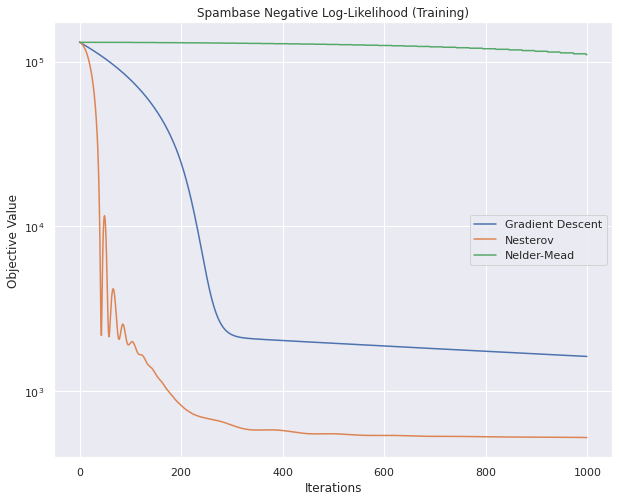

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

r = range(0, 1000)
ax.semilogy(r, [utils.nLogLike(gd[1][j], *args_train) for j in r])
ax.semilogy(r, [utils.nLogLike(ngd[1][j], *args_train) for j in r])
ax.semilogy(r, [utils.nLogLike(np.expand_dims(np.array(nms[1][j]),1), 
                               *args_train) for j in r])
            
ax.set_title('Spambase Negative Log-Likelihood (Training)')
ax.set_xlabel('Iterations')
ax.set_ylabel('Objective Value')
ax.legend(['Gradient Descent', 'Nesterov', 'Nelder-Mead']);

The plot above shows the objective value during training for all three methods we have considered. The Nesterov method performs the best, with gradient descent a little behind, and then Nelder-Mead hardly even in the same league. This is all as we would expect given Nelder-Mead doesn't use gradient information.

# Problem 2

We will again examine the *spambase* classification problem, this time with an $\ell_1$ penalty -- thus we will use our proximal gradient method.

$$ \min_w\ell(w;y,X)+\lambda||w||_1 $$

Specifically, we let $\lambda=5$ and our proximity function is given as:

$$ (y,t)\mapsto \text{prox}_{tg}(y)=\text{sign}(y)\cdot\lfloor|y|-t\lambda\rfloor_+ $$

In [6]:
def prox(y,t,l):
    f = np.abs(y)-t*l
    f[f<0] = 0
    
    return np.sign(y)*f

In [7]:
lamb = 5
ngd_p = proximalNGD(w0, f, grad, prox, t0, args=args_train, 
                    prox_args=(lamb,), return_iterates=True)

/home/rs-coop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Maximum iterations exceeded without                   reaching specified tolerance.


Having trained a new model using this penalty we are interested in examining the estimators and the overall classification accuracy. In terms of the estimators, we will compare this method against the Nesterov accelerated method without the penalty.

In [8]:
#Plot optimal weights
df = pd.DataFrame([ngd[0][:,0], ngd_p[0][:,0]])
df['Method'] = ['Standard', 'Penalty']
df = pd.melt(df, id_vars=['Method'])

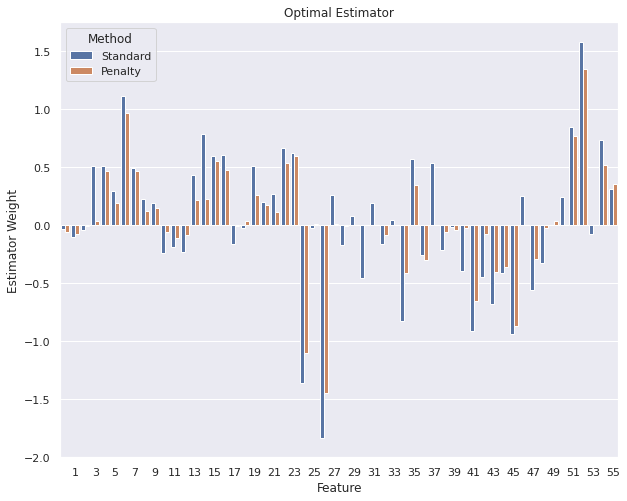

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.barplot(x='variable', y='value', hue='Method', data=df, ax=ax)
ax.set_xticks(range(1,57,2))
ax.set_xlabel('Feature')
ax.set_ylabel('Estimator Weight')
ax.set_title('Optimal Estimator');

In the plot above we can see the weights given to each feature for the Nesterov accelerated method with and without an $\ell_1$ penalty. We can see that the results are similar, but clearly the penalty method has smaller weights than the standard. This is to be expected given that the penalty is penalizing large weights. We also note that this results in more of the penalty method estimator weights being zero.

In terms of the classification accuracy, we will compare this method to all of the other methods excluding Nelder-Mead.

In [16]:
#Look at classification accuracy
weights = [gd[0], ngd[0], ngd_p[0]]
names = ['Graident Descent', 'Nesterov GD', 'Proximal GD']

stuff = []

for i in range(3):
    stuff.append([names[i], 'Train', 
                  1-utils.logisticError(weights[i], *args_train)])
    stuff.append([names[i], 'Test', 
                  1-utils.logisticError(weights[i], *args_test)])

df = pd.DataFrame(stuff, columns=['Method', 'Split', 'Accuracy'])

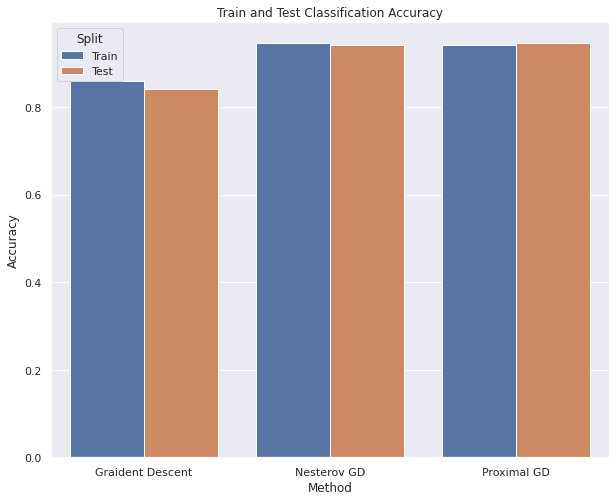

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.barplot(x='Method', y='Accuracy', hue='Split', data=df, ax=ax)
ax.set_xlabel('Method')
ax.set_ylabel('Accuracy')
ax.set_title('Train and Test Classification Accuracy');

In the plot above we can see the training and testing classification accuracies for our mehtods (with Proximal GD being the regularized approach). The Nesterov acceleration clearly improves performance as that is used in both Nesterov GD and Proximal GD. As well, it seems to help in the generalization to test data as we see less of a drop in accuracy.

# Problem 3

We will consider the problem of TV denoising for the MRI phantom image which can be seen below.

In [16]:
import pickle
Y = pickle.load(open('shepp-logan.pkl', 'rb'))
dim = Y.shape[0]

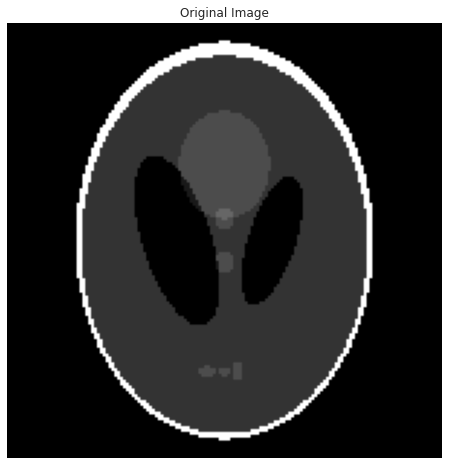

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(Y, cmap='gray')

ax.grid(False)
ax.axis(False)
ax.set_title('Original Image');

We then add noise to this image by adding noise $\sim \text{unif}(0,1)$ to a random pixel with 0.1 probability. This noisy version can be seen below.

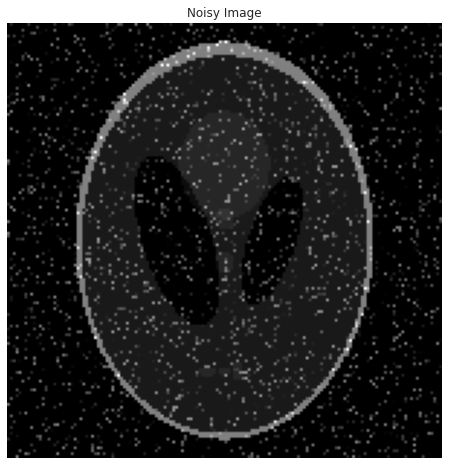

In [20]:
rng = np.random.default_rng()
mask = rng.choice([0,1], Y.shape, p=[0.9,0.1])

Y_noisy = Y + mask*rng.uniform(0, 1, Y.shape)

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(Y_noisy, cmap='gray')

ax.grid(False)
ax.axis(False)
ax.set_title('Noisy Image');

Next, we follow the material in Homework 7 to define our problem and solve it using CVXPY. First, we build a matrix that defines our discrete gradient operator.

In [21]:
#Sparse gradient matrix D using sprase versions of spdiags and kron
import scipy.sparse as sparse

data = np.array([[-1 for i in range(dim)],[1 for i in range(dim)]])
D = sparse.spdiags(data, [0,1], dim, dim)

I = sparse.identity(dim)

Lh = sparse.kron(D, I, 'csr')
Lv = sparse.kron(I, D, 'csr')

L = (Lh + Lv*1j)

Noting that the formulation above assumes the image is flattened into a vector we do this to our noisy image below.

In [22]:
Y_noisy = Y_noisy.reshape((-1,1))

Then we define a TV semi-norm function to be used in CVXPY.

In [23]:
def TV(X,L):
    return cvx.norm(L@X, 1)

Lastly we define our CVXPY function and solve it.

In [24]:
import cvxpy as cvx

t = (1/4)*TV(Y_noisy, L)

X = cvx.Variable((dim**2,1))
obj = (1/2)*cvx.sum_squares(X - Y_noisy)
con = [TV(X,L)<=t, X<=1, X>=0]
prob = cvx.Problem(cvx.Minimize(obj), con)

prob.solve();

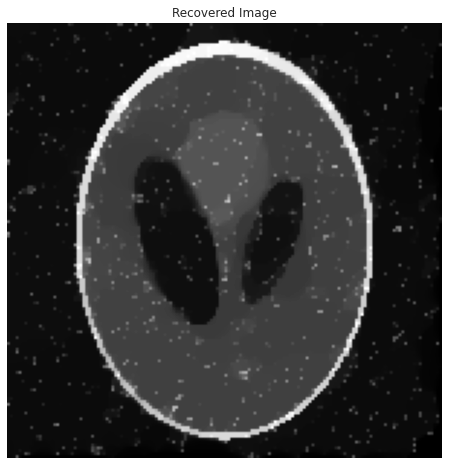

In [25]:
Y_out = X.value.reshape((dim, dim))

fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.imshow(Y_out, cmap='gray')

ax.grid(False)
ax.axis(False)
ax.set_title('Recovered Image');

Great! The recovered image is not perfectly, but clearly much better than the original noisy variant. It seems our method has worked well.